In [1]:
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
import logging
import matplotlib.pyplot as plt

from utils.data_loading import BasicDataset
from unet import UNet
from utils.utils import plot_img_and_mask

In [2]:
model = UNet(n_channels=3, n_classes=2, bilinear=True)
model.load_state_dict(torch.load("./checkpoints/checkpoint_epoch5.pth"))
model.eval()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

In [3]:
def predict_img(net,
                full_img,
                device,
                scale_factor=1,
                out_threshold=0.5):
    net.eval()
    img = torch.from_numpy(BasicDataset.preprocess(full_img, scale_factor, is_mask=False))
    img = img.unsqueeze(0)
    img = img.to(device=device, dtype=torch.float32)

    with torch.no_grad():
        output = net(img)

        if net.n_classes > 1:
            probs = F.softmax(output, dim=1)[0]
        else:
            probs = torch.sigmoid(output)[0]

        tf = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((full_img.size[1], full_img.size[0])),
            transforms.ToTensor()
        ])

        full_mask = tf(probs.cpu()).squeeze()

    if net.n_classes == 1:
        return (full_mask > out_threshold).numpy()
    else:
        return F.one_hot(full_mask.argmax(dim=0), net.n_classes).permute(2, 0, 1).numpy()

In [4]:
def get_output_filenames(args):
    def _generate_name(fn):
        split = os.path.splitext(fn)
        return f'{split[0]}_OUT{split[1]}'

    return args.output or list(map(_generate_name, args.input))

In [5]:
def mask_to_image(mask: np.ndarray):
    if mask.ndim == 2:
        return Image.fromarray((mask * 255).astype(np.uint8))
    elif mask.ndim == 3:
        return Image.fromarray((np.argmax(mask, axis=0) * 255 / mask.shape[0]).astype(np.uint8))

In [6]:
def get_predictions(input, output, model, scale, mask_threshold, no_save):
    in_files = input
    out_files = output

    net = UNet(n_channels=3, n_classes=2)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    logging.info(f'Loading model {model}')
    logging.info(f'Using device {device}')

    net.to(device=device)
    net.load_state_dict(torch.load(model, map_location=device))

    logging.info('Model loaded!')

    for i, filename in enumerate(in_files):
        logging.info(f'\nPredicting image {filename} ...')
        img = Image.open(filename)

        mask = predict_img(net=net,
                           full_img=img,
                           scale_factor=scale,
                           out_threshold=mask_threshold,
                           device=device)

#         result_mask = mask_to_image(mask)
#         imgplot = plt.imshow(result_mask)
#         plt.show()
        
        if not no_save:
            out_filename = out_files[i]
            result = mask_to_image(mask)
            imgplot = plt.imshow(result)
            result.save(out_filename)
            logging.info(f'Mask saved to {out_filename}')

        if viz:
            logging.info(f'Visualizing results for image {filename}, close to continue...')
#             plot_img_and_mask(img, mask)

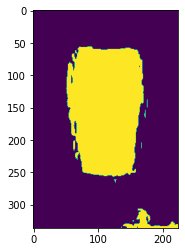

In [8]:
modelPath = "./checkpoints/checkpoint_epoch5.pth"
input = ["/data/datasets/clothing-size/train/imgs/IMG_9346.jpg"]
output = ["./prediction.jpg"]
viz = True
# Do not save the output masks
no_save = False
mask_hreshold =0.5
scale = 0.33

get_predictions(input, output, modelPath, scale, mask_hreshold, no_save)